
# Classifying Passive vs. Active Revenge in Related Subreddits using NLP

## Contents
- [Baseline Classifier](#Baseline-Classifier)
- [Logistic Regression](#Logistic-Regression)
- [Lasso Logistic Regression](#Lasso-Logistic-Regression)
- [Random Forest](#Random-Forest)
- [Multinomial Naïve Bayes](#Multinomial-Naïve-Bayes)
- [Model Evaluation](#Model-Evaluation)
- [Conclusions & Recommendations](#Conclusions-&-Recommendations)

--- 
# Part 5 : Modeling & Results

--- 

Now that our data has been scraped, cleaned, lemmatized, vectorized and visualized (EDA), we will now attempt several machine learning classification models in order to find which one performs best on our subreddit data. 

The following models were used:

* Baseline Classifier
* Logistic Regression
* Lasso Logistic Regression
* Random Forest
* Multinomial Naïve Bayes


Methodology for training each model:

- Choose hyperparameters we want to tune.
- Decide what model performance metrics to use - I use Accuracy as the main metric.
- Use TfidVectorizer to prepare our text for modeling with Pipelines & Randomized Search Cross Validation in order to find the best hyperparameters that balance bias and variance.
- Compare model performance of each model and determine which is best for as our production model.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from scipy.stats import uniform, loguniform

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [7]:
# Read in cleaned and preprocessed csv file & create df

df = pd.read_csv('../data/preprocessed_cleaned_subreddit_data.csv')

In [8]:
#Reference: https://stackoverflow.com/questions/21104592/json-to-pandas-dataframe
# Reading in our custom stop words json file we created

with open('../data/more_stopwords.json', 'r') as infile:
    more_stopwords = json.load(infile)
more_stopwords = more_stopwords['words']

In [4]:
df.head()

,author,num_comments,score,subreddit,timestamp,all_text,lems
0,Erahth,12,1,MaliciousCompliance,2021-08-01 00:11:01,one more sip so this just happened my 3 5yo so...,one more sip so this just happened my 3 5yo so...
1,MorrisonsLament,39,1,MaliciousCompliance,2021-08-01 00:12:45,you can t fire me but you can make me stop wo...,you can t fire me but you can make me stop wo...
2,infiniteknights,215,1,MaliciousCompliance,2021-08-01 00:21:24,personal responsibility ok i ve been doing al...,personal responsibility ok i ve been doing al...
3,SimRayB,19,1,MaliciousCompliance,2021-08-01 00:42:46,you put all of those in your mouth or you can ...,you put all of those in your mouth or you can ...
4,CSPhCT,28,1,MaliciousCompliance,2021-08-01 06:01:07,patient wants what he wants so i just need to ...,patient want what he want so i just need to sh...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11189 entries, 0 to 11188
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   author        11189 non-null  object
 1   num_comments  11189 non-null  int64 
 2   score         11189 non-null  int64 
 3   subreddit     11189 non-null  object
 4   timestamp     11189 non-null  object
 5   all_text      11189 non-null  object
 6   lems          11189 non-null  object
dtypes: int64(2), object(5)
memory usage: 612.0+ KB


In [9]:
# Combine pettyrevenge and ProRevenge for the target column and reclassify each class as active or passive

subs = {
    'MaliciousCompliance': 'passive',
    'pettyrevenge': 'active',
    'ProRevenge': 'active',
}

df['subreddits'] = df['subreddit']
df = df.replace({'subreddits':subs})

### Helper Function 

In [4]:
# Table of Train and Test Accuracy
# REFERENCE: Once again THANK YOU GWEN
model_accuracy = pd.DataFrame()

def add_accuracy(model, title):
    model_accuracy.loc[title, 'Train Accuracy'] = model.best_estimator_.score(
        X_train, y_train)
    model_accuracy.loc[title, 'Test Accuracy'] = model.best_estimator_.score(
        X_test, y_test)
    model_accuracy.loc[title, 'Variance'] = round(model.best_estimator_.score(
        X_train, y_train) - model.best_estimator_.score(X_test, y_test), 4)
    model_accuracy.loc[title, 'Best Params'] = str(model.best_params_)

## Baseline Classifier

We are going use the combined Active Revenge subreddits so that is our majority class. It represents 52.6% of the whole dataset as our baseline classifier. 

In [7]:
# Baseline with all 3
df['subreddit'].value_counts(normalize = True)

MaliciousCompliance    0.473948
pettyrevenge           0.300295
ProRevenge             0.225757
Name: subreddit, dtype: float64

In [8]:
# Baseline with active vs passive - I will stick with this to have a 
df['subreddits'].value_counts(normalize = True)

active     0.526052
passive    0.473948
Name: subreddits, dtype: float64

## Setting up our Data for Modeling

In [10]:
# Using perviously lemmatized column as our features
X = df['lems']
y = df['subreddits']

# Setting up our train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42, test_size=0.33)

In [19]:
# Using TF-IDF Vectors for features (this is just an initial run for a base logistic regression model)
tfidf = TfidfVectorizer(ngram_range=(1,2),
                        stop_words=more_stopwords,
                        max_features=5000)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(7496, 5000)
(3693, 5000)


## Logistic Regression

In [92]:
#Instantiate model using TF-IDF features created above
logreg = LogisticRegression(penalty='none', solver='lbfgs', max_iter=3000)

# Fit the random search model
logreg.fit(features_train, labels_train)

LogisticRegression(max_iter=3000, penalty='none')

In [93]:
logreg.score(features_train, labels_train), logreg.score(features_test, labels_test)

(0.999332977588047, 0.7330083942594097)

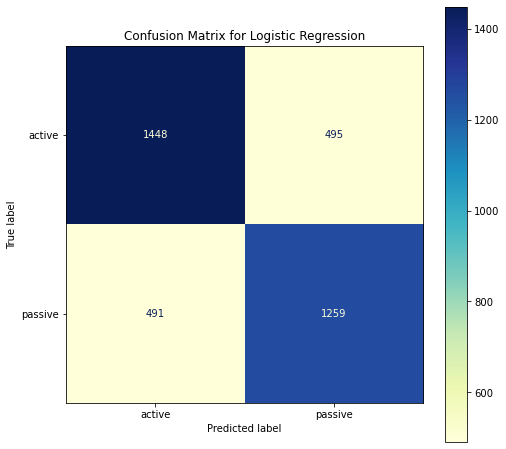

In [130]:
# Plot confusion matrix

fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(logreg, features_test, labels_test,values_format='d', cmap='YlGnBu', ax=ax)
plt.title('Confusion Matrix for Logistic Regression');

In [165]:
model_accuracy.loc['Logistic Regression','Train Accuracy'] = logreg.score(features_train, labels_train)

model_accuracy.loc['Logistic Regression','Test Accuracy'] = logreg.score(features_test, labels_test)

model_accuracy.loc['Logistic Regression', 'Variance'] = round(
    logreg.score(features_train, labels_train) - logreg.score(features_test, labels_test), 4)

model_accuracy

,Train Accuracy,Test Accuracy,Variance
Logistic Regression,0.999333,0.733008,0.2663


Terribly overfit first pass. We can do better. 

## Lasso Logistic Regression

In [18]:
# Set a pipeline
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = more_stopwords) ),
    ('ss', StandardScaler(with_mean=False) ),
    ('lr', LogisticRegression(penalty='l1', solver='liblinear', max_iter = 3000, random_state=42, verbose=0))
])

# Search over the following values of hyperparameters:
pipe_params = {
    'tfidf__max_features': [3000, 4000, 5000],
    'tfidf__min_df': [0.75, ],
    'tfidf__max_df': [0.01, 0.1, 0.5],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'lr__C': [np.linspace(0.1, 1, 10)]
}


#np.linspace(0.1,1,5)
# Instantiate RandomizedSearchCV
rs2 = RandomizedSearchCV(estimator=pipe, 
                        param_distributions = pipe_params,
                        scoring='accuracy',
                        random_state=42,
                        cv=5)

In [19]:
# Fit RandomizedSearchCV to training data

rs2.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(stop_words=['ten',
                                                                          'formerly',
                                                                          'finally',
                                                                          'help',
                                                                          'bill',
                                                                          'themselves',
                                                                          'sometime',
                                                                          'this',
                                                                          'third',
                                                                          'therefore',
                                                                          'pet

In [20]:
# What's the best score?

rs2.score(X_train, y_train), rs2.score(X_test, y_test)

(0.9685165421558164, 0.7682101272678039)

In [21]:
rs2.best_params_

{'tfidf__ngram_range': (1, 2),
 'tfidf__min_df': 2,
 'tfidf__max_features': 4000,
 'tfidf__max_df': 0.9,
 'lr__C': 0.1}

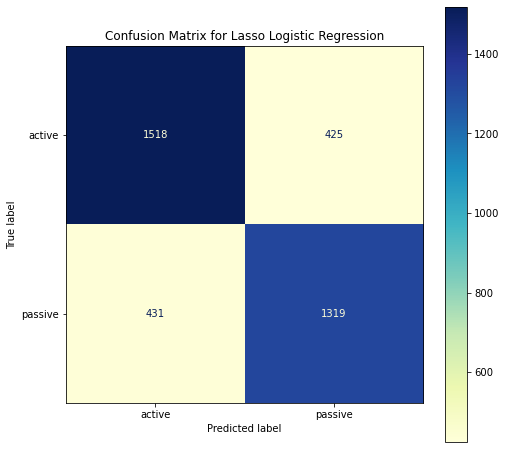

In [127]:
# Plot confusion matrix

fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(rs2, X_test, y_test,values_format='d', cmap='YlGnBu', ax=ax)
plt.title('Confusion Matrix for Lasso Logistic Regression');

In [166]:
model_accuracy.loc['Lasso Logistic Regression','Train Accuracy'] = rs2.score(X_train, y_train)

model_accuracy.loc['Lasso Logistic Regression','Test Accuracy'] = rs2.score(X_test, y_test)

model_accuracy.loc['Lasso Logistic Regression', 'Variance'] = round(
    rs2.score(X_train, y_train) - rs2.score(X_test, y_test), 4)

model_accuracy

,Train Accuracy,Test Accuracy,Variance
Logistic Regression,0.999333,0.733008,0.2663
Lasso Logistic Regression,0.968517,0.768210,0.2003


Model is still very overfit but slightly better.

## Random Forest

In [55]:
# Set a pipeline
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = more_stopwords, ngram_range=(1,2), max_df=.75, min_df=0.01)),
    ('rf', RandomForestClassifier(random_state = 42))
])

# Search over the following values of hyperparameters:
pipe_params = {'tfidf__max_features': [4000, 5000, 6000], 
          'rf__n_estimators': [100,200,300,400,500],
          'rf__max_depth': [10,20,30,40,50],
          'rf__min_samples_split': [20,30,40,50, 60],
          'rf__min_samples_leaf': [1,2,4,5,10,20],
          'rf__max_features': ['auto', 'sqrt']
              }

# Instantiate RandomizedSearchCV
rsrf = RandomizedSearchCV(estimator=pipe, 
                        param_distributions = pipe_params,
                        random_state=42,
                        cv=5)

In [56]:
# Fit RandomizedSearchCV to training data

rsrf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(max_df=0.75,
                                                              min_df=0.01,
                                                              ngram_range=(1,
                                                                           2),
                                                              stop_words=['ten',
                                                                          'formerly',
                                                                          'finally',
                                                                          'help',
                                                                          'bill',
                                                                          'themselves',
                                                                          'sometime',
                       

In [59]:
rsrf.best_score_

0.7850834778741385

In [60]:
rsrf.best_params_

{'tfidf__max_features': 4000,
 'rf__n_estimators': 300,
 'rf__min_samples_split': 30,
 'rf__min_samples_leaf': 1,
 'rf__max_features': 'sqrt',
 'rf__max_depth': 40}

In [62]:
rsrf.score(X_train, y_train), rsrf.score(X_test, y_test)

(0.9789220917822838, 0.7806661251015434)

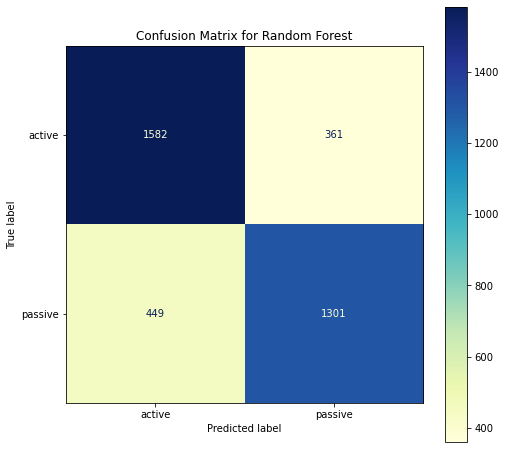

In [126]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(rsrf, X_test, y_test, values_format='d', cmap='YlGnBu', ax=ax)
plt.title('Confusion Matrix for Random Forest');

In [167]:
model_accuracy.loc['Random Forest','Train Accuracy'] = rsrf.score(X_train, y_train)

model_accuracy.loc['Random Forest','Test Accuracy'] = rsrf.score(X_test, y_test)

model_accuracy.loc['Random Forest', 'Variance'] = round(
    rsrf.score(X_train, y_train) - rsrf.score(X_test, y_test), 4)

model_accuracy

,Train Accuracy,Test Accuracy,Variance
Logistic Regression,0.999333,0.733008,0.2663
Lasso Logistic Regression,0.968517,0.768210,0.2003
Random Forest,0.978922,0.780666,0.1983


Random Forest model still overfitting... can look into adjusting some hyperparameters or even maybe bootstrapping in future iterations.

## Multinomial Naïve Bayes

In [65]:
# Set a pipeline
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = more_stopwords, ngram_range=(1,2), max_df=.75, min_df=0.01)),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters:
pipe_params = {'tfidf__max_features': [4000, 5000, 6000],
               'nb__alpha': loguniform(1, 10)
              }

# Instantiate RandomizedSearchCV
rsnb = RandomizedSearchCV(estimator=pipe, 
                        param_distributions = pipe_params,
                        random_state=42,
                        cv=5)

In [66]:
# Fit RandomizedSearchCV to training data

rsnb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(max_df=0.75,
                                                              min_df=0.01,
                                                              ngram_range=(1,
                                                                           2),
                                                              stop_words=['ten',
                                                                          'formerly',
                                                                          'finally',
                                                                          'help',
                                                                          'bill',
                                                                          'themselves',
                                                                          'sometime',
                       

In [70]:
rsnb.best_score_

0.7558673782521682

In [71]:
rsnb.best_params_

{'nb__alpha': 1.0485387725194617, 'tfidf__max_features': 5000}

In [72]:
rsnb.score(X_train, y_train), rsnb.score(X_test, y_test)

(0.7789487726787621, 0.7625236934741403)

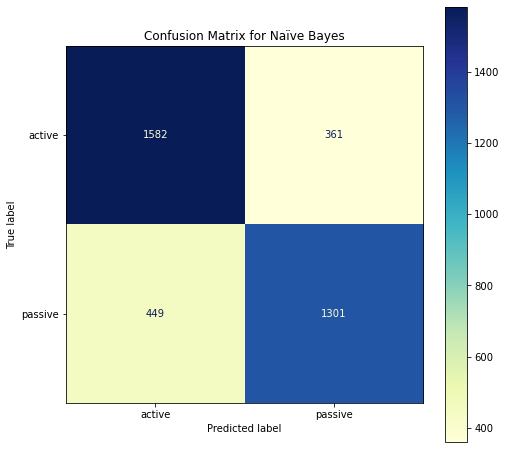

In [125]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(rsrf, X_test, y_test, values_format='d', cmap='YlGnBu', ax=ax)

plt.title('Confusion Matrix for Naïve Bayes');

BEST model yet. Lower over accuracy but a much better balance of  bias and variance! Negative feature words indicate they’re better at detecting our Passive Revenge class.

## Model Evaluation

The Naïve Bayes model is a great balance of bias and variance and a decent accuracy. It's a probabilistic classifier and there's a strong assumption that features are independent. Negative feature words indicate they’re better at detecting our Passive Revenge class. 

While my Random Forest model may have had higher train and test accuracies, the large variance was too much to ignore in terms of the model overfitting and not responding as well to data it hasn't seen before. 

### Comparison of All Models

In [168]:
model_accuracy.loc['Naïve Bayes','Train Accuracy'] = rsnb.score(X_train, y_train)

model_accuracy.loc['Naïve Bayes','Test Accuracy'] = rsnb.score(X_test, y_test)

model_accuracy.loc['Naïve Bayes', 'Variance'] = round(
    rsnb.score(X_train, y_train) - rsnb.score(X_test, y_test), 4)

In [169]:
model_accuracy

,Train Accuracy,Test Accuracy,Variance
Logistic Regression,0.999333,0.733008,0.2663
Lasso Logistic Regression,0.968517,0.768210,0.2003
Random Forest,0.978922,0.780666,0.1983
Naïve Bayes,0.778949,0.762524,0.0164


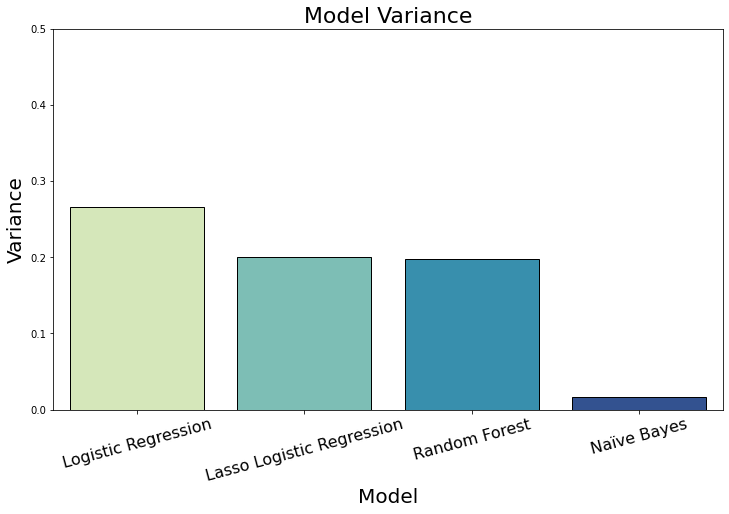

In [163]:
plt.figure(figsize=(12, 7))
sns.barplot(x=model_accuracy.sort_values('Overfitting', ascending=False).index,
            y=model_accuracy.sort_values('Overfitting', ascending=False)['Overfitting'], ec='k', 
            linewidth=1, palette='YlGnBu')
plt.xticks(rotation=15, fontsize=16)
plt.title('Model Variance', fontsize=22)
plt.ylim(0, 0.5)
plt.ylabel('Variance', fontsize=20)
plt.xlabel('Model', fontsize=20)

plt.savefig('./images/models_overfitting.png')

### Feature Importance

In [80]:
vocab = rsnb.best_estimator_.named_steps['tfidf'].get_feature_names()
coef = list(rsnb.best_estimator_.named_steps['nb'].coef_[0])
feature_df = pd.DataFrame( {'top_words': vocab, 'importance': coef })
feature_df = feature_df.set_index('top_words')
feature_df = feature_df.sort_values('importance',ascending = False)
feature_df.head(5)

,importance
top_words,
bos,-5.588541
hour,-5.621607
customer,-5.726134
minute,-5.878138
shift,-5.917564


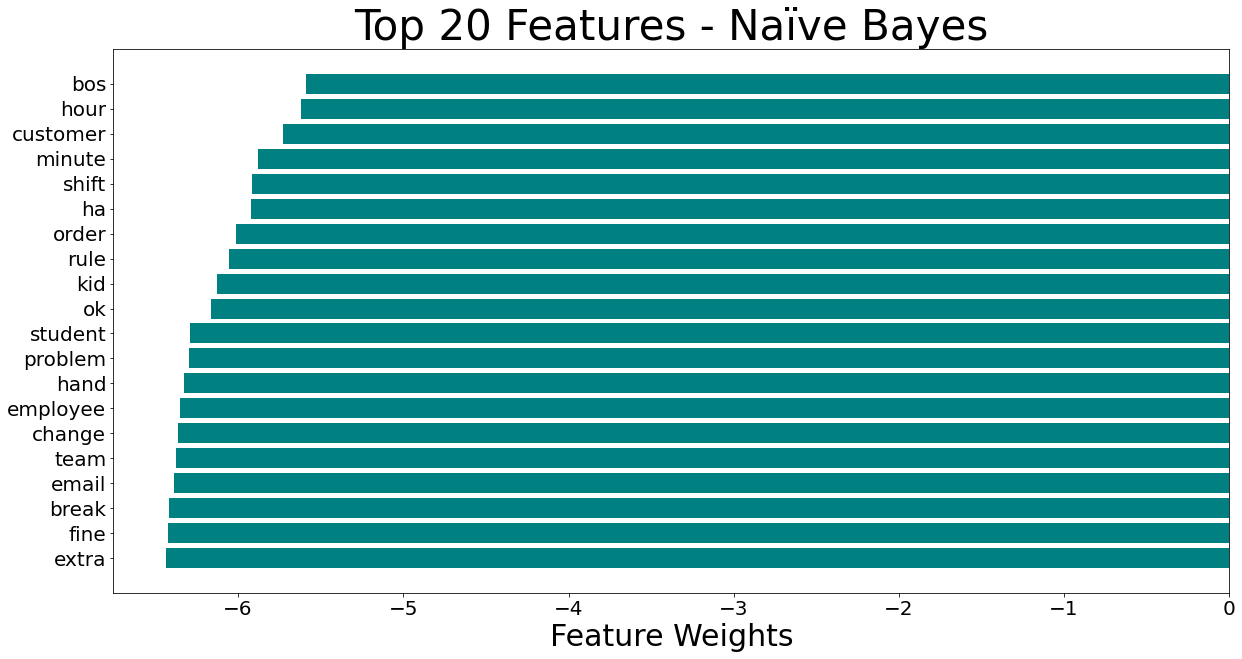

In [113]:
weights = feature_df['importance'].head(20).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = 'teal')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Feature Weights', fontsize=30)
plt.title(f'Top 20 Features - Naïve Bayes', fontsize=42)

plt.savefig('./images/top_feature_NB_pres.png')

### Misclassifications

A little more likely to predict Active when its really Passive revenge. This is one of the main reasons why I would not use this model to auto-remove submissions as you don't want to remove ones that really might belong. We made an assumption at the beginning that the submissions we pulled have already been moderated by the r/MaliciousCompliance mods and that our dataset is correctly labeled. If I was re-pulling the data right now, I think I would actually avoid using the most recent submissions scraped to make sure the submissions have all already been removed from the subreddit if they did not belong so as not to introduce 'mislabeled' data into our trained model.

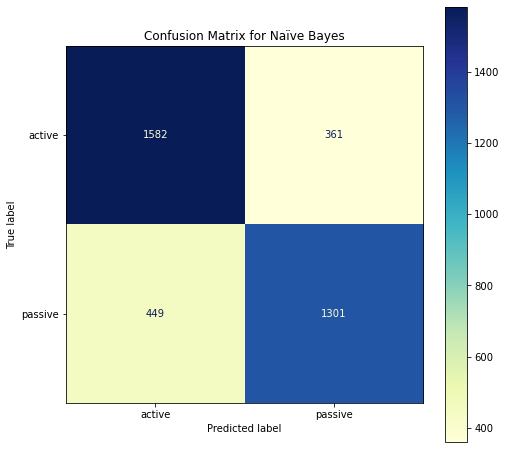

In [125]:
#Replotting Confusion Matrix for Naïve Bayes
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(rsrf, X_test, y_test, values_format='d', cmap='YlGnBu', ax=ax)

plt.title('Confusion Matrix for Naïve Bayes');

## Conclusions & Recommendations

- Beat Baseline of 52.6%
- Production model has an accuracy of 76%
- Overfitting was the largest hurdle in most models.
- Naïve Bayes may not be the best model I've ever seen in regards to its accuracy, but it is the least worst model built for this data. I think it actually would be a great tool for the r/MaliciousCompliance moderators to use as a general filter to highlight submissions that may be a better fit for other subreddits like r/pettyrevenge or r/ProRevenge. I would not use to fully auto-moderate and auto-remove submissions.
- Future improvements to this project would be spending more time tuning hyperparamters especially on my Random Forest model. I would also like to try a few other classification models like Support Vector Machine, ADA Boost or Gradient Boost.
- Another potential way to slightly improve this model would be to avoid using the most recent submissions scraped to make sure the submissions have all already been removed from the subreddit if they did not belong so as not to introduce 'mislabeled' data into our trained model.